This code takes the h5py files and use the header files to calculate the mask. Once the mask is calculated we save it into json format similar in MAsk-RCNN

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import h5py
import glob
import os
import json

empirically found an approximation by taking the dispersion
equation (delta t = 4149DM (f^-2-f0^-2)) and
solving it for f (f(t)=(t/(4149DM)+f0^-2)^-(1/2) and then computing
df=f(t)-f(t+dt). This looks similar to taking the derivative of the
function, but when doing that we get a function that is similar to the
numerical curve, but not identical.

In [2]:
def derivative_frequency(t,f0,dm,fmin,fmax):
    t0   = 4149*dm*(fmin**(-2)-f0**(-2))
    t1   = 4149*dm*(fmax**(-2)-f0**(-2))    
    tmin = np.min([t0,t1])
    tmax = np.max([t0,t1])

    # Derivative
    d = np.absolute( (2*4149*dm)**(-1)*( f0**(-2)+t/(4149*dm) )**(-1.5) )/(fmax-fmin)
    # Apply time limits
    d = np.where((t>=tmin) & (t<tmax),d,0)     
    return d

//anaconda/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power


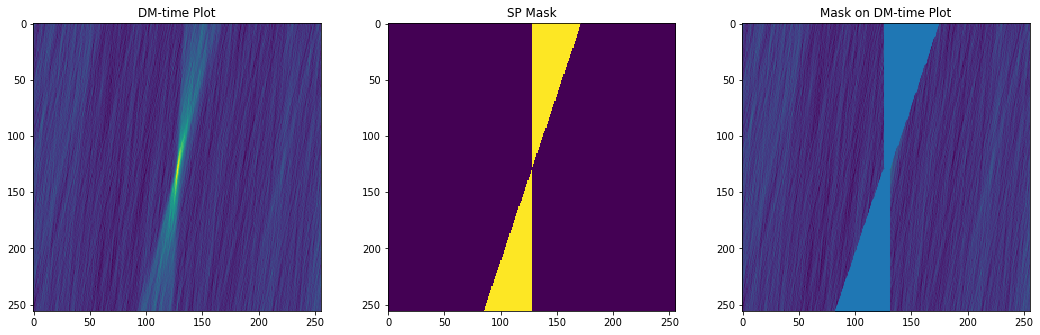

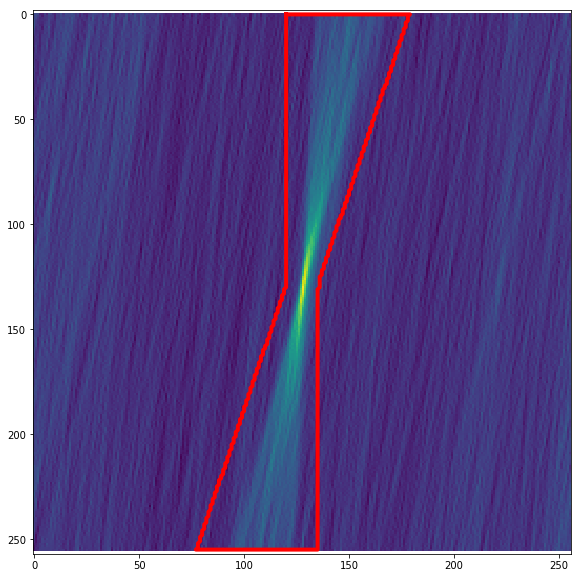

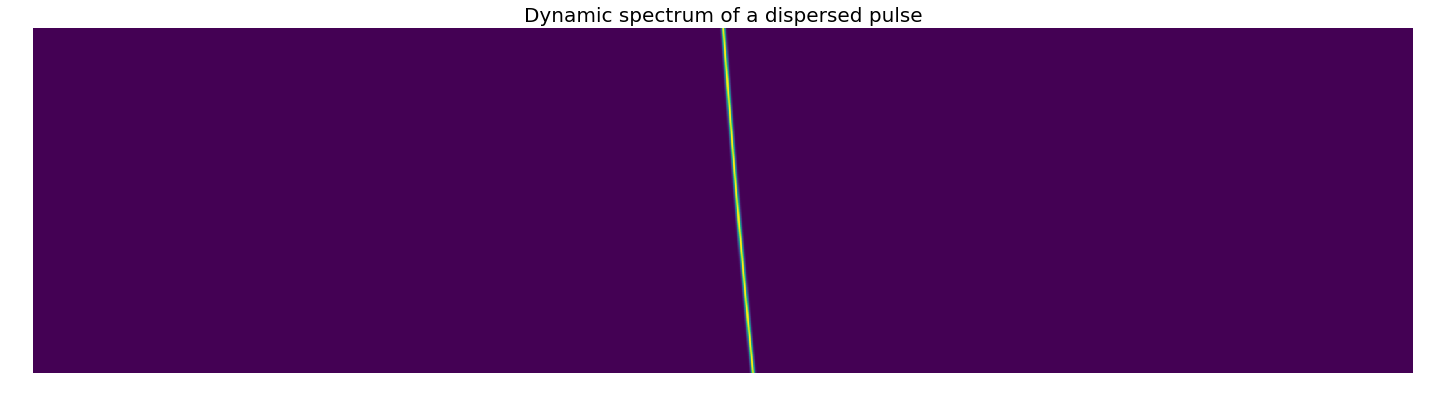

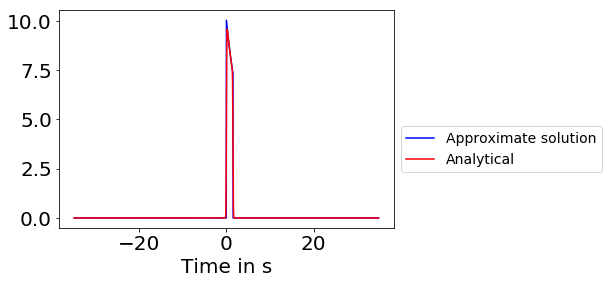

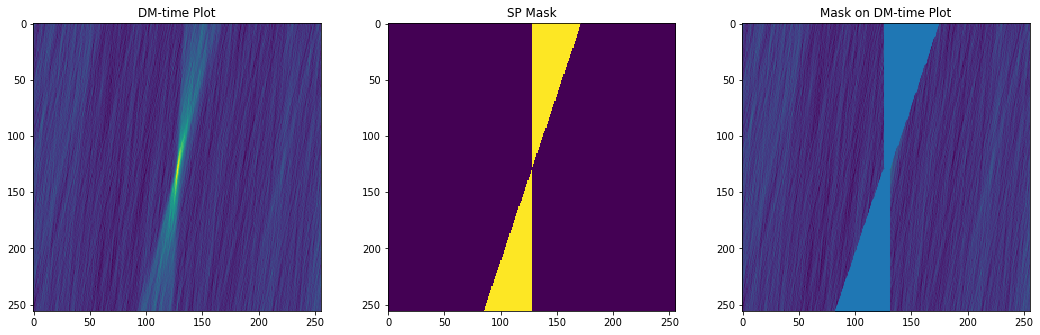

513
256


In [5]:
images_folder_name = './fetch_data/val/'  # Need to change each time you change folder
file_dir = glob.glob('./fetch_data/val/*')# Need to change each time you change folder

all_annotation = dict()
for h5_file in file_dir:
    
    with h5py.File(h5_file,'r') as f:
        dm_time = np.array(f["data_dm_time"])        
        dm            = f.attrs['dm'] # in cm-3 pc 
        tsamp         = f.attrs['tsamp'] # in s
        tstart        = f.attrs['tstart'] # in s
        nchan         = f.attrs['nchans']
        nsamp         = 2000
        fmax          = f.attrs['fch1'] # in MHz
        channel_width = f.attrs['foff'] # in MHz
        fmin          = fmax + (nchan*channel_width)
        f0            = fmax
        w             = 2*tsamp # in s
        t0            = 4149*dm*( (fmax**-2) - (f0**-2) ) #0.0

        position_dm   = np.unravel_index(dm_time.argmax(),dm_time.shape)# find coordinate of the highest intensity
        a             = dm_time[position_dm] # Intensity of highest pixel

        t     = np.linspace(-0.5*nsamp*tsamp,0.5*nsamp*tsamp,nsamp,endpoint=False) 
        f     = np.linspace(fmax,fmin,nchan,endpoint=False)
        tm,fm = np.meshgrid(t,f)

        dtm   = 4149*dm*(fm**(-2)-f0**(-2))
        z     = a*np.exp(-0.5*((tm-t0-dtm)/w)**2)/(w*np.sqrt(2*np.pi)) # Analytical

        za    = np.sum(z,axis=0)/nchan # Analytical (dynamic spectrum of a dispersed pulse collapse along the frequency axis)
        d     = derivative_frequency(t,f0,dm,fmin,fmax)*a
        
        # Plot the dynamic spectrum of a pulse
        fig, ax = plt.subplots(figsize=(20,30))
        
        ax.imshow(z)
        plt.title('Dynamic spectrum of a dispersed pulse', fontsize=20)
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('dispersepulse.pdf', bbox_inches='tight', pad_inches=0.1)
#         plt.show()
        
        plt.plot(t,d,'b',label='Approximate solution')
        plt.plot(t,za,'r',label='Analytical')
        plt.xlabel("Time in s",fontsize=20)
        plt.tick_params(axis='both', labelsize=20)
        plt.legend(loc="best",prop={'size':14},bbox_to_anchor=(1,0.5))
#         plt.show()
        
        # Compute the mask
        n         = 256#nchan
        dt        = tsamp
        time      = np.linspace(-0.5*n*tsamp,0.5*n*tsamp,n,endpoint=False) 
        dm_values = np.linspace(2*dm,0,256)    
        mask      = np.zeros(n*n).reshape(256,n) 
        for i in range(len(dm_values)):
            mask[i] = derivative_frequency(time,f0,dm_values[i]-dm,fmin,fmax)

        # Find the coordinates whose pixel values greater than 0
        snr   = np.where(mask>0.0)
        y_pix = snr[0]
        x_pix = snr[1]


        plt.figure(figsize=(18,18))
        plt.subplot(331)
        plt.imshow(dm_time)
        plt.title('DM-time Plot')

        plt.subplot(332)
        plt.imshow(mask>0.0)
        plt.title('SP Mask')

        plt.subplot(333)
        plt.scatter(x_pix,y_pix)
        plt.imshow(dm_time)
        plt.title('Mask on DM-time Plot')
#         plt.show()
        
        # Find the contour coordinates of the mask. We first find the coordinates where the pixel>0.
        # Then, for each channels, we find the coordinate of the first pixel > 0 and the coordinate of the last pixel>0
        # We know from the simulation that the FRB is located at the centre of the 256X256 pixels, therefore at the
        # centre, the white pixel list would be zero, then we put the coordinate manually to be 256/2
        
        ymin  = []
        ymax  = []
        x     = []
        image = mask
        for i in range(image.shape[0]):
            white_pix = np.array(np.where(image[i,:]>0.0))
            
            if (white_pix.shape[1]==0):
                first_pix = (image.shape[0]/2)
                last_pix  = (image.shape[0]/2)

            else:
                first_pix = min(white_pix[0,:])
                last_pix  = max(white_pix[0,:])

            x.append(i/1.)
            ymin.append(first_pix)
            ymax.append(last_pix)
        
        # We then shift the mask by 7 pixel to the right and left so that we can capture well the entire FRB without
        # losing information
        shift_pixel = 8
        ymin[:]     = [ymin_ - shift_pixel for ymin_ in ymin]
        ymax[:]     = [ymax_ + shift_pixel for ymax_ in ymax]

        # we add all the x-pixel and y-pixel. We reverse the right x-pixel and y-pixel of the FRB, so that the list 
        # become continous and then add the first coordinate of the left part of the FRB to complete the loop
        time_coor = x + x[::-1] + [x[0]] 
        dm_coor   = ymin + ymax[::-1] + [ymin[0]]


        # When performing the shifting of the pixel to the left and the right, the mask will become larger than the 
        # image size, so we need to  crop those pixel <0 and > 255 by the following command
        dm_coordinates = []
        for l in dm_coor:
            if l < 0:
                dm_ = 0
            elif l> 255:
                dm_ = 255
            else:
                dm_ = l
            dm_coordinates.append(dm_/1.)

        # We need to save those coordinates in a json file now
        print(len(time_coor)) # y-coordinates in image plane (horizontal)
        print(len(dm_values)) # x-coordinates in image plane (vertical)
        
        plt.figure(figsize=(14,10))
        plt.imshow(dm_time)
        plt.plot(dm_coordinates, time_coor,c='r',lw=4)
        plt.ylim(-2,257)
        plt.gca().invert_yaxis()
        #plt.show()        
    

        if h5_file.endswith('.h5'):
            
            size = os.path.getsize( h5_file)
            filesize = str(size)
            filename = h5_file[len(images_folder_name)::]

            img_annotation_key = filename + filesize
                        
            x_coor = dm_coordinates
            y_coor = time_coor
            id="SP"
            x = x_coor; y = y_coor;

            
            region = {'shape_attributes':{'name':'polygon','all_points_x':x,'all_points_y':y},\
                      'region_attributes':{'name':id}}

            img_annotation = {img_annotation_key:{'filename':filename,'size':size,'regions':[region]}}          


            all_annotation.update(img_annotation)
            #print(all_annotation)
            

new_json_name = 'via_region_data.json'
with open(new_json_name, 'w') as f:
    json.dump(all_annotation, f)

0
513 513


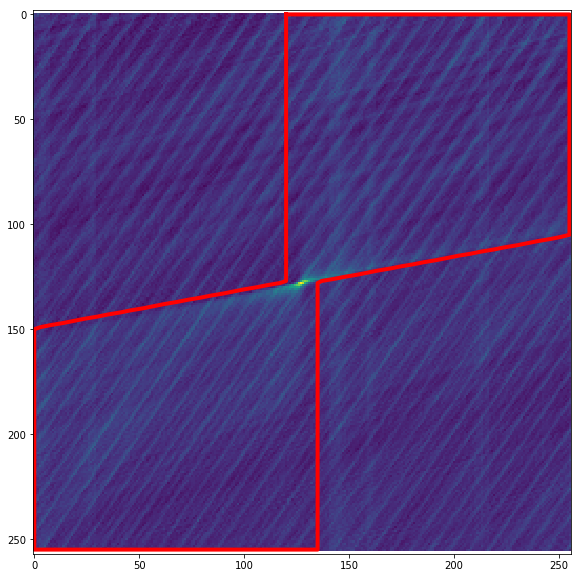

1
513 513


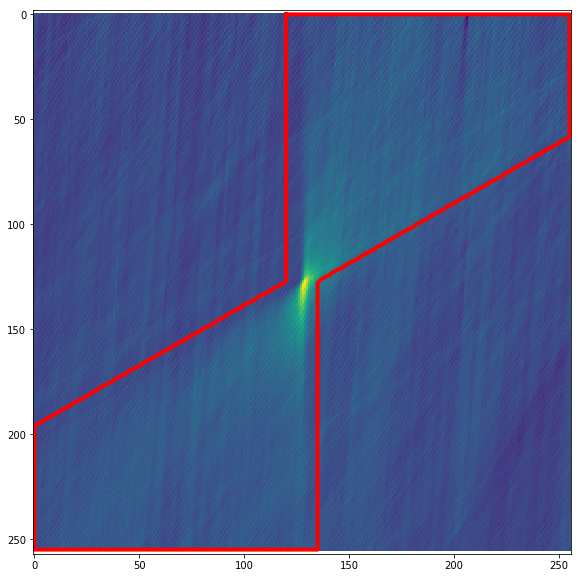

2
513 513


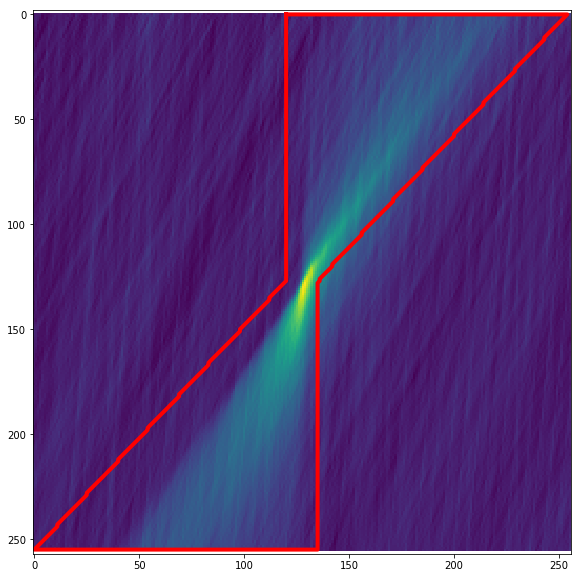

3
513 513


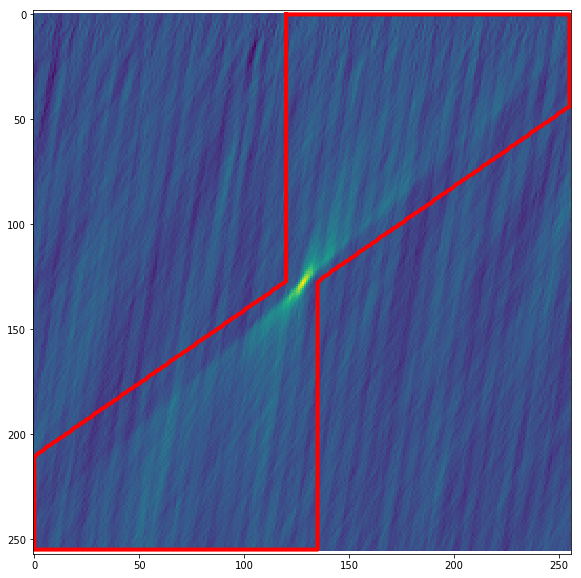

4
513 513


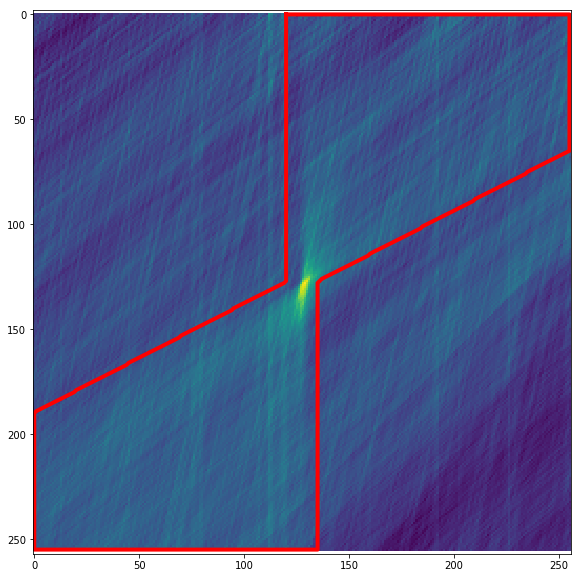

5
513 513


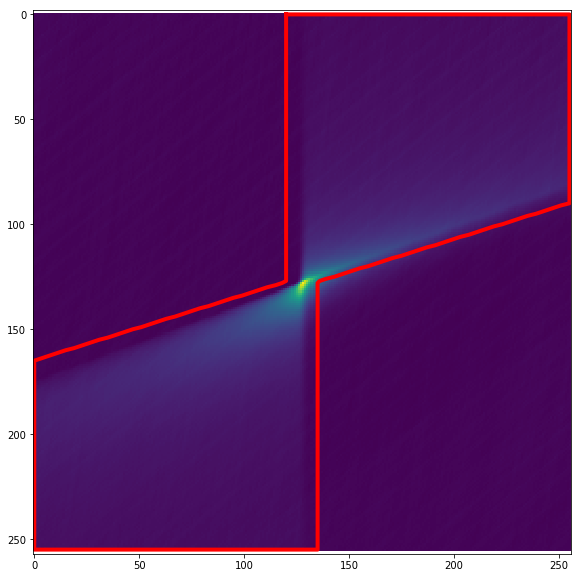

In [4]:
data_json = pd.read_json('via_region_data.json')
data_json = data_json.transpose().reset_index()[['filename','regions']]
i = 0
for h5_file in file_dir:
    
    with h5py.File(h5_file,'r') as f:
        print(i)
        dm_time = np.array(f["data_dm_time"])     
        x_mask = data_json['regions'][i][0]['shape_attributes']['all_points_x']
        y_mask = data_json['regions'][i][0]['shape_attributes']['all_points_y']
        print(len(x_mask),len(y_mask))
        dm_coordinates = x_mask; time_coor=y_mask;
        plt.figure(figsize=(14,10))
        plt.imshow(dm_time)
        plt.plot(dm_coordinates, time_coor,c='r',lw=4)
        plt.ylim(-2,257)
        plt.gca().invert_yaxis()
        plt.show()        
    
        i+=1
